<a href="https://www.kaggle.com/code/siddp6/simple-skip-connection?scriptVersionId=138508286" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [67]:
import utility

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Initalisation

In [69]:
input_size, hidden_size, output_size = 10, 50, 5
num_samples = 1000
epochs = 500
input_data = torch.rand(num_samples, input_size)
target_data = torch.rand(num_samples, output_size)
loss_normal_3, loss_normal_6 = list(), list()
loss_skip_3, loss_skip_6 = list(), list()

# Normal Model (3 layered) (without skip-connection)

In [70]:
class NormalNet3(nn.Module):
    def __init__(self, input_size, output_size):
        super(NormalNet3, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = F.relu(self.layer_1(X))
        X = F.relu(self.layer_2(X))
        X = self.layer_3(X)
        
        return X

In [71]:
normal_model3 = NormalNet3(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(normal_model3.parameters(), lr=.01)

In [72]:
loss_normal_3 = utility.train_model(normal_model3, epochs, input_data, target_data, criterion, optimizer, 50)

Epoch [50/500], Loss: 0.1435
Epoch [100/500], Loss: 0.0967
Epoch [150/500], Loss: 0.0883
Epoch [200/500], Loss: 0.0872
Epoch [250/500], Loss: 0.0870
Epoch [300/500], Loss: 0.0869
Epoch [350/500], Loss: 0.0868
Epoch [400/500], Loss: 0.0867
Epoch [450/500], Loss: 0.0867
Epoch [500/500], Loss: 0.0866


# Normal Model (7 layered) (without skip-connection)

In [73]:
class NormalNet7(nn.Module):
    def __init__(self, input_size, output_size):
        super(NormalNet7, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)        
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, hidden_size)
        self.layer_4 = nn.Linear(hidden_size, hidden_size)
        self.layer_5 = nn.Linear(hidden_size, hidden_size)
        self.layer_6 = nn.Linear(hidden_size, hidden_size)
        self.layer_7 = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = F.relu(self.layer_1(X))
        X = F.relu(self.layer_2(X))
        X = F.relu(self.layer_3(X)) 
        X = F.relu(self.layer_4(X)) 
        X = F.relu(self.layer_5(X)) 
        X = F.relu(self.layer_6(X)) 
        X = self.layer_7(X)
        
        return X

In [74]:
normal_model7 = NormalNet7(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(normal_model7.parameters(), lr=.01)

In [75]:
loss_normal_7 = utility.train_model(normal_model7, epochs, input_data, target_data, criterion, optimizer, 50)

Epoch [50/500], Loss: 0.2170
Epoch [100/500], Loss: 0.1619
Epoch [150/500], Loss: 0.1287
Epoch [200/500], Loss: 0.1089
Epoch [250/500], Loss: 0.0975
Epoch [300/500], Loss: 0.0911
Epoch [350/500], Loss: 0.0877
Epoch [400/500], Loss: 0.0859
Epoch [450/500], Loss: 0.0850
Epoch [500/500], Loss: 0.0845


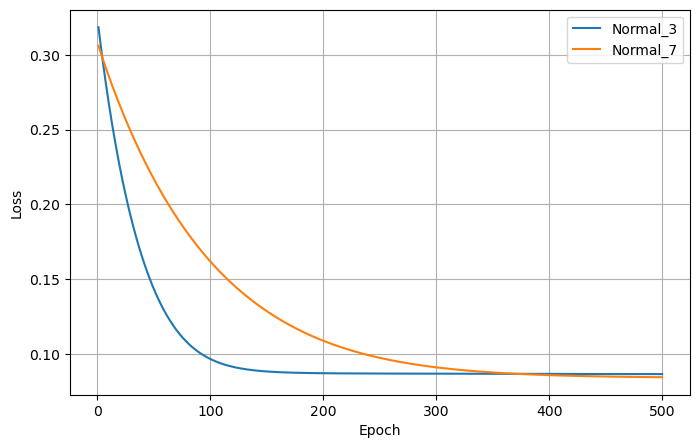

In [76]:
utility.plot_loss({"Normal_3": loss_normal_3, "Normal_7": loss_normal_7}, epochs)

# Skip Model (3 layered) (with skip-connection)

In [77]:
class SkipNet3(nn.Module):
    def __init__(self, input_size, output_size):
        super(SkipNet3, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        skip_connection = X
        
        X = F.relu(self.layer_1(X))
        X = F.relu(self.layer_2(X))
        X = self.layer_3(X + skip_connection)
        
        return X

In [78]:
skip_model3 = SkipNet3(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(skip_model3.parameters(), lr=.01)

In [79]:
loss_skip_3 = utility.train_model(skip_model3, epochs, input_data, target_data, criterion, optimizer, 5)

RuntimeError: The size of tensor a (50) must match the size of tensor b (10) at non-singleton dimension 1

# Skip Model (7 layered) (with skip-connection)

In [80]:
class SkipNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SkipNN, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, 512)        
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_5 = nn.Linear(64, 32)
        self.layer_6 = nn.Linear(32, 16)
        self.layer_7 = nn.Linear(16, output_size)
        
    def forward(self, X):
        skip_connection = X
        
        X1 = F.relu(self.layer_1(X))
        X2 = F.relu(self.layer_2(X1)) + X1
        X3 = F.relu(self.layer_3(X2)) + X1
        X4 = F.relu(self.layer_4(X3)) + X1
        X5 = F.relu(self.layer_5(X4)) + X1
        X6 = F.relu(self.layer_6(X5)) + X1
        X7 = self.layer_7(X6 + skip_connection)
        
        return X7

In [81]:
skip_model = SkipNN(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(skip_model.parameters(), lr=.01)

In [82]:
loss_skip = utility.train_model(skip_model, epochs, input_data, target_data, criterion, optimizer, 5)

RuntimeError: The size of tensor a (256) must match the size of tensor b (512) at non-singleton dimension 1

# Analysis

In [83]:
utility.plot_loss({"Normal": loss_normal, "Skip": loss_skip}, epochs)

NameError: name 'loss_normal' is not defined